# Introduction

Plot figures of Descheemaeker & de Buyl, 2020 (DOI: 10.7554/eLife.55650).

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [2]:
from noise_properties_plotting import noise_cmap_ww, noise_lim
%matplotlib inline

import sys
sys.path.insert(1, '../sglv_timeseries')

from sglv_timeseries.glv.Timeseries import Timeseries
from sglv_timeseries.noise_parameters import NOISE
from sglv_timeseries.models import MODEL

from sglv_timeseries.timeseries_plotting import PlotTimeseries, PlotRankAbundance

#from neutral_covariance_test import *

from noise_analysis import noise_color
from scipy import stats
from scipy.optimize import curve_fit
from neutrality_analysis import KullbackLeibler_neutrality
from neutral_covariance_test import neutral_covariance_test

# code for plotting
from noise_properties_plotting import PiecewiseNormalize

import matplotlib

%load_ext autoreload

%autoreload 2

load sglv_timeseries
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Figure settings

In [3]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [4]:
## Figure functions

In [5]:
def noise_colorbar_ax(ax):
    x = np.linspace(0.9, -3, 500).reshape([500,1])
    
    ax.imshow(x, cmap=noise_cmap_ww, vmin = noise_lim[0], vmax= noise_lim[1], 
              extent=(0, 1, -3, 0.9), aspect='auto', alpha=0.75)
    ax.set_ylabel('Noise color')
    ax.set_xticks([])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

# Figures

## Figure 1: Overview experimental data

In [6]:
data_path = 'Data/'

def load_experimental_data():
    # Load dataframes

    # MartinPlatero plankton data

    df_ts = {}

    path = 'MartinPlatero/'
    files = ['41467_2017_2571_MOESM5_ESM_MartinPlatero_Plankton_Eukarya.csv',
             '41467_2017_2571_MOESM4_ESM_MartinPlatero_Plankton_Bacteria.csv']
    keys = ['plankton_eukarya', 'plankton_bacteria'] 

    for i, f in enumerate(files):
        x = pd.read_csv(data_path+path+f, na_values='NAN', index_col=0)
        x = x.iloc[:, :-1] # delete last columns which contains details on the otu's

        # only keep 200 most abundant species
        sum_x = x.sum(axis='columns')

        x = x[sum_x >= np.sort(sum_x)[-200]]

        x = x.T # species are in rows instead of columns

        x.insert(0, 'time', [int(j[4:7]) for j in x.index]) # day

        x = x.groupby('time').agg('mean').reset_index()

        x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]

        df_ts[keys[i]] = x


    # David stool data

    files = [data_path + 'Faust/25_timeseries/25_timeseries.txt']
    keys = ['David_stool_A']

    for i, f in enumerate(files):
        x = pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)

        x = x.T

        x.insert(0, 'time', range(len(x)))

        x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]

        df_ts[keys[i]] = x

    # Caporaso body sites data

    sites = ['F4_L_palm_L6', 'F4_tongue_L6']

    for site in sites:
        file = data_path + 'Caporaso/' + site + '.txt'
        key = 'Caporaso_' + site

        x = pd.read_csv(file, delimiter='\t', skiprows=1, index_col=0, header=None)
        
        x.index = ['time'] + ['species_%d' % j for j in range(1, len(x.index))]

        x = x.T

        # only keep 200 most abundant species
        if len(x.columns) > 201:
            sum_x = x.sum(axis='rows')

            sum_x['time'] = np.inf

            sum_x.sort_values(ascending=False, inplace=True)

            x = x[sum_x.index.tolist()[:201]]

        x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]

        df_ts[key] = x
    return df_ts

def calculate_noise_color(df_ts, keys=['plankton_eukarya', 'David_stool_A',
            'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']):
    # calculate noise color
    df_ns = {}

    for i, key in enumerate(keys):
        ts = df_ts[key]
        ns = noise_color(ts)
        df_ns[key] = ns['slope_linear']
        df_ns[key + '_std'] = ns['std_slope_linear']
    return df_ns

def calculate_width_distribution(df_ts, keys=['plankton_eukarya', 'David_stool_A',
            'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']):
    # calculate width distribution

    df_disdx = {}

    def fit_ratio(x):
        x = x[:-1] / x[1:] # ratios of succesive time points
        x = x[np.isfinite(x)] # remove infinities
        x = x[x>0]

        if len(x) > 5:
            a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
            stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
            # (null hypothesis: ratios of succesive time points follow lognorm distribution)
            
            #nbins = 15                                                                                                                                                                                                                                                                                                                                                                                                                                             
            #n, bins = np.histogram(x, nbins, density=True)       

            #centers = (0.5*(bins[1:]+bins[:-1]))

            #pars, cov = curve_fit(lambda x, a, b, c : 
            #                      stats.lognorm.pdf(x,a,b,c), 
            #                      centers, n, p0=[a,b,c])  

            #ax.plot(centers, norm.pdf(centers,*pars), 'k--',linewidth = 2, label='fit before')                                                                                                                                                                                 
            #ax.set_title('$\mu={:.4f}\pm{:.4f}$, $\sigma={:.4f}\pm{:.4f}$'.format(pars[0],np.sqrt(cov[0,0]), pars[1], np.sqrt(cov[1,1 ])))                                                                                                                                                                              

            return a, b, c, stat, pval, np.nan #cov[0,0]
        else:
            return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    count = 0

    for i, key in enumerate(keys):
        ts = df_ts[key]

        dx_ratio = pd.DataFrame(index=ts.columns, columns=['s', 'loc', 'scale', 'ks-stat', 'ks-pval', 's_std'])
        dx_ratio.drop('time', inplace=True)

        for idx in dx_ratio.index:
            fit_par = fit_ratio(ts[idx].values)
            dx_ratio.loc[idx] = fit_par

            if False and fit_par[-1] > 0.5 and count < 10:
                print(key, idx, fit_par[-1])

                print(x[:5])

                x = ts[idx].values
                x_transf = x[:-1] / x[1:] # ratios of succesive time points
                x_transf = x_transf[np.isfinite(x_transf)] # remove infinities

                a, b, c, _, pval = fit_par

                x_fit = np.logspace(-1.5,1.5,100)
                pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
                plt.figure()
                plt.hist(x_transf, alpha=0.4, normed=True, bins = np.logspace(-1.5,1.5,30))
                plt.plot(x_fit, pdf_fitted, label='%.2f, %.2f, %.2f'%(a,b,c))
                plt.xscale('log')
                plt.legend()
                plt.show()

                count += 1

        if count == 10:
            break;

        df_disdx[key] = dx_ratio
    
    return df_disdx

In [7]:
df_ts = load_experimental_data()
df_ns = calculate_noise_color(df_ts)
df_disdx = calculate_width_distribution(df_ts)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


In [8]:
def all_characteristics_ax(key, ax_ts=None, ax_ra=None, ax_nc=None, ax_dx=None, ax_disdx=None,
                          axes_legend_ts=None, axes_legend_ra=None, axes_cbar_nc=None, axes_cbar_disdx=None, show_std=False):
    ts = df_ts[key]
    ts_mean = df_ts[key].mean()
    ts_median = df_ts[key].median()
    ts_std = df_ts[key].std()
    ts_mean.drop('time', inplace=True)
    ts_median.drop('time', inplace=True)
    ts_std.drop('time', inplace=True)
    ts['time'] -= ts['time'].min()
    
    ranks = [1, 5, 10, 50, 100]

    # Time series.
    if ax_ts != None:
        PlotTimeseries(ts, ax_ts, raw=True, species_rank=ranks)
        
        if axes_legend_ts != None:
            handles, labels = ax_ts.get_legend_handles_labels()
            axes_legend_ts.legend(handles, labels, handlelength=1, fontsize=ELIFE.FONTSIZE)
        
    # Rank abundance.
    if ax_ra != None:
        # Plot rank abundance of selected time points.
        selected_times = [0, 49, 99, 149]
        
        for t in selected_times:
            abundance_profile = ts[ts['time'] == t].drop('time', axis=1)
            PlotRankAbundance(abundance_profile, labels='Day %d' % (int(t)+1), # t + 1 because python counts from 0
                              ax=ax_ra, relative=False, raw=True)
            #ax_ra.get_legend().remove()
        
        # Show mean and std of rank abundance curve.
        sorted_ts = np.copy(ts.to_numpy()); sorted_ts.sort(axis=1)
        sorted_mean, sorted_std = np.mean(sorted_ts, axis=0), np.std(sorted_ts, axis=0)
            
        ax_ra.fill_between(range(1, len(sorted_mean)+1), (sorted_mean - sorted_std)[::-1],
                    (sorted_mean + sorted_std)[::-1], alpha=0.2, color='grey')
    
        if axes_legend_ra != None:
            handles, labels = ax_ra.get_legend_handles_labels()
            axes_legend_ra.legend(handles, labels, handlelength=1, fontsize=ELIFE.FONTSIZE)
          
    # Noise color.
    if ax_nc != None:
        markers, caps, bars = ax_nc.errorbar(ts_mean, df_ns[key], yerr=df_ns[key + '_std'], 
                                          xerr = ts_std if show_std else None,
                         fmt='o', markersize=1, color='grey')
        [bar.set_alpha(0.2 if show_std else 0.4) for bar in bars]
        
        if axes_cbar_nc != None:
            xx = np.linspace(0.9, -3, 500).reshape([500,1])
            axes_cbar_nc.imshow(xx, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], 
                                extent=(0, 1, -3, 0.9),
                     aspect='auto', alpha=0.75)

            axes_cbar_nc.set_ylabel('Noise color')
            axes_cbar_nc.set_xticks([])
            axes_cbar_nc.yaxis.set_label_position("right")
            axes_cbar_nc.yaxis.tick_right()
        
    # Absolute value step.
    if ax_dx != None:
        dx = (ts.values[1:, 1:] - ts.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)
        median_dx = np.nanmedian(abs(dx), axis=0)
        
        x = np.log10(ts_mean[ts_mean != 0])
        y = np.log10(mean_dx[ts_mean != 0])
        p_lin, cov = np.polyfit(x, y, deg=1, cov=True)

        xx = [ts_mean[ts_mean > 0].min(), ts_mean.max()]
        ax_dx.plot(xx, 10 ** (p_lin[1] + p_lin[0] * np.log10(xx)), c='k', linewidth=0.5)
        ax_dx.annotate(r'y $\propto$ x$^{%.2f \pm %.2f} $' % (p_lin[0], np.sqrt(cov[0,0])),(0.3,0.01))
        
        markers, caps, bars = ax_dx.errorbar(ts_mean, mean_dx, xerr = ts_std if show_std else None,
                         fmt='o', markersize=1, color='grey')
        [bar.set_alpha(0.2) for bar in bars]

    # Width ratios of subsequent points.
    if ax_disdx != None:
        dx_ratio = df_disdx[key]
        
        if show_std:
            markers, caps, bars = ax_disdx.errorbar(ts_mean, dx_ratio['s'], xerr = ts_std,
                         fmt='o', markersize=1, color='grey')
            [bar.set_alpha(0.2) for bar in bars]
            
        sc = ax_disdx.scatter(ts_mean, dx_ratio['s'], c=dx_ratio['ks-pval'], vmin=0, vmax=1, cmap='coolwarm', s=3, zorder=10)
        
        if axes_cbar_disdx != None:
            plt.colorbar(sc, cax=axes_cbar_disdx)
            axes_cbar_disdx.set_ylabel('p-value lognormal fit')
    return

def overview_experimental_data_figure(keys, titles, show_std=False):
    fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,7), tight_layout=True)

    # Set up all axes

    # Define grids for axes.
    lm = 0.15 # left margin
    rm = 0.85 # right margin

    gs_ts = gridspec.GridSpec(2, len(keys), top=0.97, bottom=0.7, left = lm, right=rm, hspace=0.5, wspace=0.1)
    gs_ma = gridspec.GridSpec(3, len(keys), top=0.65, bottom=0.22, left = lm, right=rm, hspace=0.05, wspace=0.1)
    gs_legend = gridspec.GridSpec(2, 1, top=0.97, bottom=0.7, left = 0.88, right=0.99, hspace=0.5, wspace=0.1)
    gs_cbar = gridspec.GridSpec(3, 1, top=0.65, bottom = 0.22, left = 0.88, right=0.9, hspace=0.05, wspace=0.1)

    gs_neut = gridspec.GridSpec(2,1,hspace=0, left=lm, right= rm, top=0.15, bottom=0.11) # for neutrality
    gs_neut_cbar = gridspec.GridSpec(1,2,wspace=0.2, left=lm, right = rm, top = 0.07, bottom=0.05) # for colorbars neutrality

    # Make arrays for all axes.
    axes = [[0 for i in range(len(keys))] for j in range(5)]
    # Axes of timeseries and rank abundance.
    for i in range(2):
        for j in range(len(keys)):
            if j == 0: # share axes except for timeseries
                axes[i][j] = fig.add_subplot(gs_ts[i,j])
                if i == 0:
                    axes[i][j].set_title(titles[i])
            elif i == 0:
                axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0])
                axes[i][j].set_title(titles[j])
            else:
                axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0], sharex=axes[i][0])
            axes[i][j].grid()

    # Axes of statistical measures.
    for i in range(2,5):
        for j in range(len(keys)):
            if i-2 == 0 and j == 0: # share axes except for timeseries
                axes[i][j] = fig.add_subplot(gs_ma[i-2,j])
            elif i-2 == 0:
                axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0], sharex=axes[i][0])
            elif j == 0:
                axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharex=axes[i-1][j])
            else:
                axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0], sharex=axes[i-1][j])
            axes[i][j].grid()
    axes = np.array(axes)
    
    # Axes colorbars and legends.
    axes_cbar_nc = fig.add_subplot(gs_cbar[0], sharey=axes[2][0])
    axes_cbar_pval = fig.add_subplot(gs_cbar[-1])
    axes_legend_ts = fig.add_subplot(gs_legend[0]); axes_legend_ts.axis('off')
    axes_legend_ra = fig.add_subplot(gs_legend[-1]); axes_legend_ra.axis('off')
    
    # Axes for neutrality measures and their colorbars.
    ax_KL = fig.add_subplot(gs_neut[0])
    ax_clb_KL = fig.add_subplot(gs_neut_cbar[0])
    ax_NCT = fig.add_subplot(gs_neut[1])
    ax_clb_NCT = fig.add_subplot(gs_neut_cbar[1])
    ax_KL.set_facecolor('lightgrey')
    ax_NCT.set_facecolor('lightgrey')
    
    # Put A-F labels at all rows.
    for ax, label in zip(axes[:,0], ('A', 'B', 'C', 'D', 'E')):
        ax.text(-0.72, 1.05, label, transform=ax.transAxes,
          fontsize=10, fontweight='bold', va='top', ha='right')
    ax_KL.text(-0.72*0.23, 1.05, 'F', transform=ax_KL.transAxes,
          fontsize=10, fontweight='bold', va='top', ha='right')
    
    for i, key in enumerate(keys):
        ax_ts, ax_ra, ax_nc, ax_dx, ax_disdx = axes[:5, i]
        
        # Plot all characteristics of one time series.
        all_characteristics_ax(key, ax_ts, ax_ra, ax_nc, ax_dx, ax_disdx,
                                                      axes_legend_ts, axes_legend_ra, axes_cbar_nc, axes_cbar_pval)

        if i == 0:
            # Boundaries of axes. Set in log-scale.
            vmin = 1e-4; vmax = 1e5

            ax_ts.set_ylim([vmin, vmax])
            ax_ra.set_ylim([vmin, vmax])
            ax_nc.set_ylim([-3,2])
            ax_ra.set_xlim([5e-1,3e2])
            ax_dx.set_ylim([1e-3, 5e4])
            ax_disdx.set_xlim([1e-3, 5e4])
            ax_disdx.set_ylim([8e-2, 8e0])

            # Log scale.
            ax_ts.set_yscale('log')
            ax_nc.set_xscale('log')
            ax_dx.set_xscale('log')
            ax_dx.set_yscale('log')
            ax_disdx.set_xscale('log')
            ax_disdx.set_yscale('log')

            # Hide x tick labels for shared x axes.
            for ax in [ax_nc, ax_dx]:
                plt.setp(ax_nc.get_xticklabels(), visible=False)

            # Labels
            ax_ts.set_ylabel('Abundance')
            ax_ra.set_ylabel('Abundance')
            ax_nc.set_ylabel('Slope power \n spectral density')
            ax_dx.set_ylabel('Difference \n time points \n' + r'$\left< \mid x(t+\delta t) - x(t) \mid \right>$')
                #'Mean absolute \n difference between successive \n time points')
            ax_disdx.set_ylabel('Width distribution \n of ratios \n' + r'$x(t + \delta t) / x(t)$')

            # Add colorbars and legend only once.
            axes_legend_ts, axes_legend_ra, axes_cbar_nc, axes_cbar_pval = (None, ) * 4
        else:
            # Hide y ticks labels for shared axes.
            for ax in [ax_ts, ax_ra, ax_nc, ax_dx, ax_disdx]:
                plt.setp(ax.get_yticklabels(), visible=False)
        
        # X-labels and x tick labels.
        if i == len(keys) - 1:
            ax_ts.set_xlabel('Time (days)', ha='right', x=1)
            ax_nc.set_xlabel('Rank', ha='right', x=1)
            ax_nc.set_xticks([10,100])
            ax_nc.set_xticklabels([10,100])
            ax_disdx.set_xlabel('Mean abundance', ha='right', x=1)
            ax_disdx.set_xticks([1e-2, 1e1, 1e4])

    # Neutrality measures.

    neutrality = pd.read_csv('results/experimental/neutrality.csv', index_col=0)
    neutrality = neutrality.loc[keys]
    
    # Plot values of Kullback Leibler divergence.
    x = neutrality['KL'].to_numpy(dtype=np.float64)
    colors = np.log10(x.reshape([1, len(x)])); colors[np.isinf(colors)] = 3
    mat_KL = ax_KL.matshow(colors, origin='lower', cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)
    
    # Write values of Kullback Leibler divergence.
    for i, xx in enumerate(x):
        ax_KL.text(i, 0, '{:0.2E}'.format(xx), ha='center', va='center', color='w' if xx < 10 ** (0.5) else 'k')
    
    # Plot values of neutral covariance test.
    x = neutrality['NCT'].to_numpy(dtype=np.float64)
    colors = np.log10(x.reshape([1, len(x)]))
    vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
    norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
    mat_NCT = ax_NCT.matshow(colors, origin='lower', norm=norm, 
                         cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
    
    # Write values of neutral covariance test.
    for i, xx in enumerate(x):
        ax_NCT.text(i, 0, '{:0.2E}'.format(xx), ha='center', va='center', color='w' if xx < 10 ** (-3) or xx > 10 ** (-0.7) else 'k')
    fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')
    
    # Put labels for KL divergence and NCT.
    ax_KL.set_yticks([0])
    ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'])         
    ax_NCT.set_yticks([0])
    ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'])

    # Remove ticks of neutrality plots.
    ax_NCT.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)
    ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)
    
    # Colorbar for KL divergence and NCT.
    fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
    ax_clb_KL.set_xlabel(r'log$_{10}$($D_{KL}$)', ha='right', x=1)
    
    for ax, neutral_tick, niche_tick in zip([ax_clb_KL, ax_clb_NCT], 
                                             [0.05, 1+(vmax + np.log10(0.05))/(vmax - vmin)/2],
                                             [0.95, 1+(vmin + np.log10(0.05))/(vmax - vmin)/2]):
        ax_twin = ax.twiny()
        ax.xaxis.set_ticks_position('bottom')
        ax_twin.xaxis.set_ticks([neutral_tick,niche_tick])
        ax_twin.set_xlim([0,1])
        ax_twin.xaxis.set_ticklabels(['neutral','niche'])
        ax_twin.tick_params(axis='x', direction='out')

    fig.align_ylabels(axes[:,0])

    return fig


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


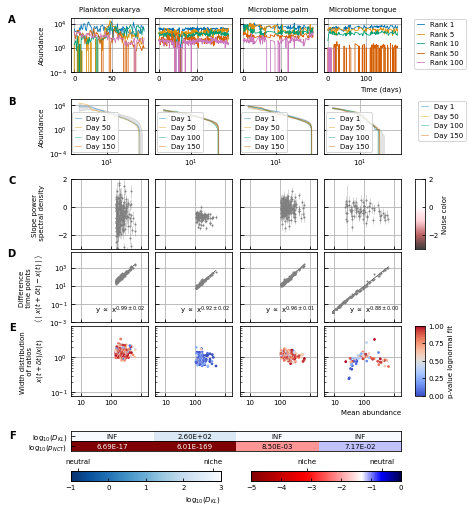

In [9]:
keys = ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton eukarya', 'Microbiome stool', 
          'Microbiome palm', 'Microbiome tongue']

overview_experimental_data_figure(keys, titles, show_std=False)
#plt.savefig('figures_elife/experimental_summary3.pdf')
plt.show()

## Figure 2: Noise color

In [75]:
def read_file(file, r=None, encoding=1):
    if encoding == 1:
        x = pd.read_csv(file)
        
        ss = x['steady state'].astype('float').multiply(r)

        x = x[[col for col in x if col.endswith('slope')]]
        return ss, np.mean(x.T), np.std(x.T)
    elif encoding == 2:
        x = pd.read_csv(file, index_col=0)
        
        ss = x.loc['means'] # steady state
        mean_color = x.loc['mean_color']
        std_color = x.loc['std_color']
        
        return ss, mean_color, std_color
    return
 
def comparison_ax(files, labels, title, rescale=1, ax=0, mapper=None, encoding=1, raw=False):
    if ax == None:
        fig = plt.figure(figsize=(4,3.5), tight_layout=True)
        ax = fig.add_subplot(111) # 122
    
    ax.set_xscale('log')
    
    if isinstance(rescale, (int, float, complex)):
        rescale = np.full_like(files, rescale, dtype=float)
    elif rescale == None:
        rescale = np.full_like(files, 1, dtype=float)
        
    for i, (f, label, r) in enumerate(zip(files, labels, rescale)):
        ss, y, yerr = read_file(f, r=r, encoding=encoding)
        
        # plot 1 in x points such that plot is not too heavy and the results are alternated 
        # such that the results for the different labels are visible
        skipper = 1 if len(ss) < 100 else len(labels) if len(ss) < 300 else len(labels) + 5
           
        ax.errorbar(ss[i%skipper::skipper], y[i%skipper::skipper], yerr[i%skipper::skipper], 
                    linestyle='', marker='.', label=label, markersize=3, 
                   c = mapper.to_rgba(float(label)) if mapper != None else None)
    
    if not raw:
        ax.set_xlabel(r'Mean abundance $\times$ self-interaction')
        ax.set_ylabel('Slope power spectral density')

    # legend from low to high
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title=title, loc=2, ncol=2 if len(handles)>3 else 1)

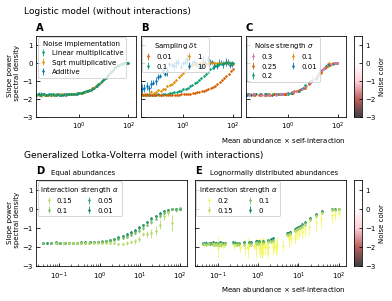

In [80]:
def noise_color_implementation_figure():
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 4), tight_layout=True)

    # Grids for all axes.
    yoff = 0.01

    gs_top = gridspec.GridSpec(1, 3, top=0.88+yoff, bottom=0.6+yoff,
                               left=0.1, right=0.88, wspace=0.05, hspace=0.05)
    gs_top_colorbar = gridspec.GridSpec(1, 1, top=0.88+yoff, bottom=0.6+yoff,
                                        left=0.9, right=0.92, wspace=0.05, hspace=0.05)

    gs_top_comb = gridspec.GridSpec(
        1, 1, top=0.95+yoff, bottom=0.55+yoff, left=0.07, right=0.88)

    gs_bottom = gridspec.GridSpec(
        1, 2, top=0.38+yoff, bottom=0.08+yoff, left=0.1, right=0.88, wspace=0.05, hspace=0.05)
    gs_bottom_colorbar = gridspec.GridSpec(1, 1, top=0.38+yoff, bottom=0.08+yoff,
                                           left=0.9, right=0.92, wspace=0.05, hspace=0.05)

    gs_bottom_comb = gridspec.GridSpec(
        1, 1, top=0.45+yoff, bottom=0.03+yoff, left=0.07, right=0.88)

    # Labels and titles (with and without interactions)
    for title, gs in zip(['Logistic model (without interactions)', 'Generalized Lotka-Volterra model (with interactions)'],
                         [gs_top_comb[0], gs_bottom_comb[0]]):
        ax = fig.add_subplot(gs, frameon=False)
        ax.text(0, 1.08, title, transform=ax.transAxes,
                fontsize=9, va='top', ha='left')
        ax.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)
        ax.set_ylabel('Slope power \n spectral density')
        ax.set_xticks([])
        ax.set_yticks([])

    axes = {'A': fig.add_subplot(gs_top[0])}
    for i, letter in enumerate(['B', 'C'], start=1):
        axes[letter] = fig.add_subplot(
            gs_top[i], sharex=axes['A'], sharey=axes['A'])
    axes['D'] = fig.add_subplot(gs_bottom[0])
    for i, letter in enumerate(['E'], start=1):
        axes[letter] = fig.add_subplot(
            gs_bottom[i], sharex=axes['D'], sharey=axes['D'])

    for letter in ['A', 'B', 'C', 'D', 'E']:
        axes[letter].text(0, 1.05, letter, transform=axes[letter].transAxes,
                          fontsize=10, fontweight='bold', va='bottom', ha='left')

    # Color bars
    for gs, share_letter in zip([gs_top_colorbar[0], gs_bottom_colorbar[0]], ['A', 'D']):
        ax_cbar = fig.add_subplot(gs, sharey=axes[letter])
        noise_colorbar_ax(ax_cbar)

    # Logistic equations (without interactions)
    path = 'results/without_interactions/'

    # implementation
    files_noise = [path + 'noise_abundance_Langevin_linear.csv',
                   path + 'noise_abundance_Langevin_sqrt.csv',
                   path + 'noise_abundance_Langevin_constant.csv'][::-1]

    labels = ['Linear multiplicative', 'Sqrt multiplicative', 'Additive'][::-1]

    comparison_ax(files_noise, labels, 'Noise implementation', ax=axes['A'], raw=True)
    axes['A'].set_xlim([2e-2, 2e2])

    # sampling dt

    files_noise_samp = [
        path + 'noise_abundance_Langevin_samp%d_c.csv' % i for i in range(1, 12)]
    labels = ['0.005', '0.01', '0.025', '0.05',
              '0.1', '0.25', '1', '2', '2.5', '5', '10']

    # make selection
    select = [1, 4, 6, 10]
    files_noise_samp, labels = np.array(files_noise_samp)[
        select], np.array(labels)[select]

    comparison_ax(files_noise_samp[::-1], labels[::-1],
                  'Sampling $\delta$t', ax=axes['B'], raw=True)


    # noise strength

    files_noise_sigma = [
        path + 'noise_abundance_Langevin_linear_sigma%d.csv' % d for d in range(1, 6)]

    labels = ['0.01', '0.1', '0.2', '0.25', '0.3']

    comparison_ax(files_noise_sigma[::-1], labels,
                  'Noise strength $\sigma$', ax=axes['C'], raw=True)

    # gLV equations (with interactions)

    norm = PiecewiseNormalize([0, 0.21], [0, 1])
    mapper = plt.cm.ScalarMappable(norm=norm, cmap='summer')

    axes['D'].text(0.1, 1.05, 'Equal abundances', transform=axes['D'].transAxes,
                   fontsize=ELIFE.FONTSIZE, va='bottom', ha='left')

    path = 'results/with_interactions/'
    files_noise_int = [
        path + 'noisecolor_Langevin_linear_interaction%d.csv' % d for d in [1, 2, 3, 6]]

    labels = ['0.01', '0.05', '0.1', '0.15']

    comparison_ax(files_noise_int, labels, r'Interaction strength $\alpha$',
                  mapper=mapper, ax=axes['D'], encoding=2, raw=True)

    axes['E'].text(0.1, 1.05, 'Lognormally distributed abundances', transform=axes['E'].transAxes,
                   fontsize=ELIFE.FONTSIZE, va='bottom', ha='left')
    #ax.set_title('Lognormally distributed abundances')

    path = 'results/with_interactions/'
    files_noise_pl = [
        path + 'noisecolor_Langevin_linear_powerlaw_sigma%d.csv' % d for d in range(1, 5)]

    labels = ['0', '0.1', '0.15', '0.2']

    comparison_ax(files_noise_pl, labels, r'Interaction strength $\alpha$',
                  mapper=mapper, ax=axes['E'], encoding=2, raw=True)

    # Remove tick labels of shared axes
    for letter in ['B', 'C', 'E']:
        axes[letter].tick_params(axis="both", left=True, labelleft=False)

    # Set boundaries y-axis
    for letter in ['A', 'D']:
        ymin = -3
        ymax = 1.5
        axes[letter].set_ylim([ymin, ymax])

    # Set boundaries x-axis
    axes['A'].set_xlim([2e-2, 2e2])
    
    return fig

noise_color_implementation_figure()
# plt.savefig('figures_elife/noisecolor_summary4.pdf')
plt.show()

## Figure 3: Width step distribution

In [12]:
#df1 = pd.read_csv('results/width_ratios/width_lognormal_fit_1.csv')
#df2 = pd.read_csv('results/width_ratios/width_lognormal_fit_1_interaction0.05.csv')
#df3 = pd.read_csv('results/width_ratios/width_lognormal_fit_1_interaction0.1.csv')
#df4 = pd.read_csv('results/width_ratios/width_lognormal_fit_1_interaction0.15.csv')

Logistic equations (no interactions)


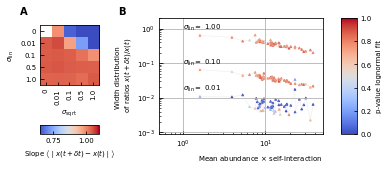

gLV equations (with interactions)


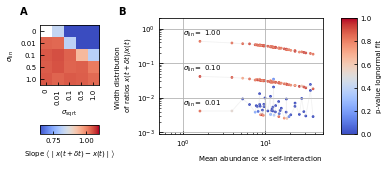

In [39]:
def width_step_figure(with_interactions=False):
    mapper = plt.cm.ScalarMappable(
        norm=PiecewiseNormalize([0, 0.21], [0, 1]), cmap='summer')

    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH, 2.3))

    # Grid for axes.
    gs_l = gridspec.GridSpec(2, 1, height_ratios=[8, 1], hspace=0.8,
                             right=0.25, left=0.1, top=0.9, bottom=0.2)
    gs_r = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[10, 1], hspace=0.15, wspace=0.2,
                             right=0.9, left=0.4, top=0.9, bottom=0.2)

    # Define axes.
    ax_mat = fig.add_subplot(gs_l[0])
    ax = fig.add_subplot(gs_r[:, 0])

    ax_mat_cbar = fig.add_subplot(gs_l[1])
    ax_cbar = fig.add_subplot(gs_r[:, 1])

    # Label figures (A-B).
    ax_mat_tot = fig.add_subplot(gs_l[:])
    ax_mat_tot.axis('off')

    ax_mat_tot.text(-0.2, 1.1, 'A', transform=ax_mat_tot.transAxes,
                    fontsize=10, fontweight='bold', va='top', ha='right')
    ax.text(-0.2, 1.1, 'B', transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')

    # Matrix
    
    # TODO check difference between if and else
    if not with_interactions:
        df_slopes2 = pd.read_csv('results/slopes/slopes_equal_abundances.csv',
                                 index_col=0, na_values='NAN')
        df_slopes2['slope'] = df_slopes2.iloc[:, 2:12].mean(axis=1)
        df_slopes2['slope_std'] = df_slopes2.iloc[:, 2:12].std(axis=1)
        df_slopes2.drop(['%d' % i for i in range(10)], axis=1, inplace=True)

        slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std'], axis=1)
        std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope'], axis=1)

        slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
        std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

        slope = slope.unstack()

        val = slope.values        
    else:
        df_slopes = pd.read_csv('results/slopes/interaction_005.csv', index_col=0, na_values='NAN')
        df_slopes2 = df_slopes.loc[df_slopes.implementation == 'NOISE.LANGEVIN_LINEAR_SQRT'].copy()
        
        Nts = 10
        
        df_slopes2.loc[:,'slope'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].mean(axis=1)
        df_slopes2.loc[:,'slope_std'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].std(axis=1)
        df_slopes2.drop(['ts_%d'%i for i in range(Nts)], axis=1, inplace=True)
        
        slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std', 'noise_ct'], axis=1)
        std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope', 'noise_ct'], axis=1)

        slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
        std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

        slope = slope.unstack()
        std_slope = std_slope.unstack().iloc[:4, :4]

        val = slope.values
        val[0][0] = np.nan
    
    mat = ax_mat.matshow(val, cmap='coolwarm', vmin=0.65, vmax=1.1)
    ax_mat.set_xlabel(r'$\sigma_\mathregular{sqrt}$')
    ax_mat.set_ylabel(r'$\sigma_\mathregular{lin}$')
        
    # Ticks
    ax_mat.set_xticks([0, 1, 2, 3, 4])
    ax_mat.set_yticks([0, 1, 2, 3, 4])
    ax_mat.set_xticklabels([0, 0.01, 0.1, 0.5, 1.0], rotation=90)
    ax_mat.set_yticklabels([0, 0.01, 0.1, 0.5, 1.0])
    ax_mat.tick_params(axis='both', top=False, bottom=True,
                       labelbottom=True, labeltop=False)

    # colorbar
    cbar = plt.colorbar(mat, cax=ax_mat_cbar, orientation='horizontal')
    cbar.set_label(r'Slope $\left< \mid x(t+\delta t) - x(t) \mid \right>$')

    # Right plot
    sigmas = [0.01, 0.1, 1.0]

    dfs = []
    
    if with_interactions:
        df = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental.csv')
        m = 'o' # marker
    else:
        df = pd.read_csv('results/width_ratios/width_lognormal_fit_experimental_interaction.csv')
        m = '^' # marker

    for j, sigma in enumerate(sigmas):
        # Get width, p-value, steady state and selfinteraction.
        w = df[['sigma_%.2f_width_mean_%d' %
                (sigma, d) for d in range(20)]].median(axis=1).values
        pval = df[['sigma_%.2f_pval_%d' %
                   (sigma, d) for d in range(20)]].median(axis=1).values
        ss = df['ss'].values
        si = df['selfints'].values
        
        # Define x = steady state * selfinteraction
        x = ss * si

        # Sort values.
        p = x.argsort()

        x = x[p]
        w = w[p]
        pval = pval[p]
        ss = ss[p]
        si = si[p]
        
        # Plot widths
        #col = mapper.to_rgba(alpha) # color
        ax.plot(x, w, c='lightgrey', alpha=0.3)
        
        s_ax = ax.scatter(x, w, s=3, c=pval, cmap='coolwarm',
                          vmin=0, vmax=1, marker=m)
        
        xl = 1e0; yl = w[0] # position label
        ax.annotate(r"$\sigma_\mathregular{lin} =$ %.2f" % sigma, xy=(
                xl, yl), xytext=(xl, 1.5*yl), ha='left')
    
    # orientation='horizontal')
    cbar = plt.colorbar(s_ax, cax=ax_cbar, orientation='vertical')
    cbar.set_label('p-value lognormal fit')

    # Labels
    ax.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)
    ax.set_ylabel('Width distribution \n of ratios ' + r'$x(t + \delta t) / x(t)$')

    # Boundaries axes
    ax.set_xlim([5e-1, 5e1])
    ax.set_ylim([9e-4, 2e0])

    # Scale axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.grid()
    
    return fig

print("Logistic equations (no interactions)")
width_step_figure()
# plt.savefig('figures_elife/interaction_lognormal_fit2.pdf')
plt.show()

print("gLV equations (with interactions)")
width_step_figure(with_interactions=True)
# plt.savefig('figures_elife/interaction_lognormal_fit2.pdf')
plt.show()

## Figure 4: Example time series

In [69]:
def experimental_abundance_noise_color():
    x = df_ts['David_stool_A']
    
    # Do not consider the traveling
    x = x.loc[150:].copy()
    
    x.drop('time', axis=1, inplace=True)
    
    experimental_abundance = np.sort(x.values[0,:])[::-1]
    experimental_noise_color = noise_color(x.values.T)
    
    return experimental_abundance, experimental_noise_color


In [70]:
def plot_timeseries_comparison(files, titles=[], ffig=None, mean_slope=False,
                               composition=['ts', 'psd', 'nc', 'dx', 'disdx', 'ra', 'nn'], 
                               vertical=True, fig=0, show_std = False):
    if fig != 0 and isinstance(fig, matplotlib.axes.Axes) and len(composition) > 1 and len(files) > 1:
        raise ValueError("fig / ax / multiple compositions / multiple files")

    if fig == 0:
        if vertical == True:
            fig = plt.figure(figsize=(3 * len(files), 2.5 * len(composition))) #, tight_layout=True)
            gs = gridspec.GridSpec(len(composition), len(files), top=0.9, bottom=0.2, wspace=0.5, left=0.1, right=0.9)
        else:
            fig = plt.figure(figsize=(3 * len(composition), 2.5 * len(files))) #, tight_layout=True)
            gs = gridspec.GridSpec(len(files), len(composition), top=0.9, bottom=0.2, wspace=0.5,
                                   width_ratios=[2 if ci == 'nn' else 3 for ci in composition], left=0.1, right=0.9)

    for i, f in enumerate(files):
        if isinstance(f, str):
            x = pd.read_csv(f, na_values='NAN')
        elif isinstance(f, pd.DataFrame):
            x = f.copy()

        mean = x.mean()
        mean.drop('time', inplace=True)
        std = x.std()
        std.drop('time', inplace=True)
        
        vmin = 0.1 * np.nanmin(mean.values[mean.values != np.inf])
        vmax = 10 * np.nanmax(mean.values[mean.values != np.inf])

        # make all axes

        if i == 0:
            if fig != 0 and isinstance(fig, matplotlib.axes.Axes) and len(composition) == 1:
                globals()['ax_' + composition[0]] = fig
            elif fig != 0 and composition == ['nn'] and len(fig) == 2:
                globals()['ax_KL'] = fig[0]
                globals()['ax_NCT'] = fig[1]
            else:
                for c in composition:
                    if vertical == True:
                        row = composition.index(c)
                        col = i
                    else:
                        col = composition.index(c)
                        row = i

                    if c == 'nn':
                        sub_gs = gs[row, col].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
                        globals()['ax_KL'] = fig.add_subplot(sub_gs[1])
                        globals()['ax_NCT'] = fig.add_subplot(sub_gs[2])
                    else:
                        globals()['ax_' + c] = fig.add_subplot(gs[row, col])

            if 'ts' in composition:
                ax_ts.set_ylabel('Abundance')

            if 'nc' in composition:
                ax_nc.set_ylabel('Slope power \n spectral density')

            if 'dx' in composition:
                ax_dx.set_ylabel('Mean absolute \n step')

            if 'ra' in composition:
                ax_ra.set_ylabel('Abundance')
        else:
            for c in composition:
                if vertical == True:
                    row = composition.index(c)
                    col = i
                else:
                    col = composition.index(c)
                    row = i

                if c == 'nn':
                    sub_gs = gs[row, col].subgridspec(4, 1, height_ratios=[2, 1, 1, 2])
                    globals()['ax_KL'] = fig.add_subplot(sub_gs[1])
                    globals()['ax_NCT'] = fig.add_subplot(sub_gs[2])
                else:
                    globals()['ax_' + c] = fig.add_subplot(gs[row, col])

        # set title
        if len(titles) == len(files):
            globals()['ax_' + composition[0]].set_title(titles[i])

        skip = max(1, int(len(x) / 500))

        N = len(x.columns) - 1

        if 'ts' in composition or 'psd' in composition:
            # plot different mean abundances, first sort the species
            sorted_species = mean.sort_values().index.tolist()[::-1]

            skip = max(1, int(len(x) / 500))
            for species in sorted_species[::max(1, int(N / 4))]:
                if 'ts' in composition:
                    ax_ts.plot(x['time'][::skip], x[species][::skip])

                if 'psd' in composition:
                    example_noise_fit(ax_psd, x[species])

                    if i > 0:
                        ax_psd.set_ylabel('')

            if 'ts' in composition:
                ax_ts.set_xlabel('Time', ha='right', x=1)
                ax_ts.set_yscale('log')

        if ('psd' in composition and mean_slope) or 'nc' in composition:
            nc = noise_color(x)
            ns = nc['slope_linear']

            if 'psd' in composition:
                ax_psd.legend([], [], title='mean slope = %.2f + %.2f' % (np.mean(ns), np.std(ns)))

            if 'nc' in composition:
                markers, caps, bars = ax_nc.errorbar(mean, ns, yerr=nc['std_slope_linear'], xerr = std if show_std else None,
                         fmt='o', markersize=1, color='grey')
                [bar.set_alpha(0.2 if show_std else 0.4) for bar in bars]
        
                ax_nc.set_xscale('log')
                ax_nc.set_xlabel('Mean abundance', ha='right', x=1)

        if 'dx' in composition:
            dx = (x.values[1:, 1:] - x.values[:-1, 1:])  # / x.values[:-1, 1:];
            dx[~np.isfinite(dx)] = np.nan
            mean_dx = np.nanmean(abs(dx), axis=0)

            p_lin, cov = np.polyfit(np.log10(mean[~np.isnan(mean_dx)]), np.log10(mean_dx[~np.isnan(mean_dx)]), deg=1,
                               cov=True)

            xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
            ax_dx.plot(xx, 10 ** (p_lin[1] + p_lin[0] * np.log10(xx)), c='k', linewidth=0.5)
                      # label= 'y $\propto$ x$^{%.2f}$' % p_lin[0])
            ax_dx.text(0.95, 0.05, r'y $\propto$ x$^{%.2f \pm %.2f}$' % (p_lin[0], np.sqrt(cov[0,0])), 
                       transform=ax_dx.transAxes, va='bottom', ha='right')
            
            markers, caps, bars = ax_dx.errorbar(mean, mean_dx, yerr=None, xerr = std if show_std else None,
                         fmt='o', markersize=1, color='grey')
            [bar.set_alpha(0.2 if show_std else 0.4) for bar in bars]
        
            if np.log10(max(mean[mean > 0])) - np.log10(min(mean[mean > 0])) > 1:
                ax_dx.set_xscale('log')
            if np.log10(max(mean_dx[mean_dx > 0])) - np.log10(min(mean_dx[mean_dx > 0])) > 1:
                ax_dx.set_yscale('log')
            ax_dx.set_xlabel('Mean abundance', ha='right', x=1)
            ax_dx.legend(loc=4, frameon=False)
            #ax_dx.grid()

        if 'disdx' in composition:
            def fit_ratio(x):
                x = x[:-1] / x[1:]
                x = x[np.isfinite(x)]

                if len(x) > 5:
                    a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
                    stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c)))

                    return a, b, c, stat, pval
                else:
                    return (np.nan, np.nan, np.nan, np.nan, np.nan)

            dx_ratio = pd.DataFrame(index=x.columns, columns=['s', 'loc', 'scale', 'ks-stat', 'ks-pval'])
            dx_ratio.drop('time', inplace=True)

            for idx in dx_ratio.index:
                dx_ratio.loc[idx] = fit_ratio(x[idx].values)  # b = 0, c = 1

            ax_disdx.scatter(mean, dx_ratio['s'], c=dx_ratio['ks-pval'], vmin=0, vmax=1, cmap='coolwarm', s=3, zorder=10)
            markers, caps, bars = ax_disdx.errorbar(mean, dx_ratio['s'], yerr=None, xerr = std if show_std else None,
                         fmt='o', markersize=1, color='grey')
            [bar.set_alpha(0.2 if show_std else 0.4) for bar in bars]
            
            ax_disdx.set_xscale('log')
            ax_disdx.set_yscale('log')
            ax_disdx.set_ylabel('Width step\n distribution')
            ax_disdx.set_xlabel('Mean abundance', ha='right', x=1)

            ax_disdx.set_xlim([vmin, vmax])
            ax_disdx.set_ylim([1e-3, 1e2])

        if 'ra' in composition:
            selected_times = [0, 50, 100, 150] #x['time'][::int(len(x['time']) / 3)]

            for t in selected_times:
                abundance_profile = x[x['time'] == t].values.flatten()[1:]
                ax_ra.plot(range(1, len(abundance_profile) + 1), np.sort(abundance_profile)[::-1],
                           label='Day %d' % int(t))
            
            sorted_ts = np.copy(ts.to_numpy()); sorted_ts.sort(axis=1)
            sorted_mean, sorted_std = np.mean(sorted_ts, axis=0), np.std(sorted_ts, axis=0)
            
            ax.fill_between(range(1, len(sorted_mean)+1), (sorted_mean - sorted_std)[::-1],
                    (sorted_mean + sorted_std)[::-1], alpha=0.2, color='grey')
        
            ax_ra.set_xlabel('Rank', ha='right', x=1)
            ax_ra.set_xscale('log')
            ax_ra.set_yscale('log')
            ylim = ax_ra.get_ylim()
            ax_ra.set_ylim([max(1e-5, ylim[0]), ylim[1]])
            ax_ra.legend(ncol=2, columnspacing=0.5)

        if 'nn' in composition:
            KL = KullbackLeibler_neutrality(x, verbose=False)
            norm_ts = x.values[:, 1:].copy()
            norm_ts /= norm_ts.sum(axis=1, keepdims=True)
            NCT = neutral_covariance_test(norm_ts, ntests=500, method='Kolmogorov', seed=56)
            print('NCT', NCT)
            
            ax_KL.matshow([[np.log10(KL)]], cmap='Blues_r', vmin=-1, vmax=3, aspect='auto', )
            ax_KL.set_xticks([])
            ax_KL.set_yticks([0])
            ax_KL.set_yticklabels([r'$D_{KL}$'], fontsize=ELIFE.FONTSIZE)
            ax_KL.tick_params(axis="both", left=False, labelleft=True)
            ax_KL.text(0, 0, '{:0.2E}'.format(KL), ha='center', va='center', color='w' if KL < 10 ** (0.5) else 'k')
            
            norm = PiecewiseNormalize([-5, np.log10(0.05), 0], [0, 0.5, 1])
            ax_NCT.matshow([[np.log10(NCT)]], norm=norm, cmap='seismic_r', aspect='auto', vmin=-5, vmax=0)
            ax_NCT.set_xticks([])
            ax_NCT.set_yticks([0])
            ax_NCT.set_yticklabels([r'$p_{NCT}$'], fontsize=ELIFE.FONTSIZE)
            ax_NCT.tick_params(axis="both", left=False, labelleft=True)
            ax_NCT.text(0, 0, '{:0.2E}'.format(NCT), ha='center', va='center',
                        color='w' if NCT < 10 ** (-3) or NCT > 10 ** (-0.7) else 'k')


        if len(titles) == len(files) and not np.any(np.isnan(x.values)):
            print(titles[i], KullbackLeibler_neutrality(x))

    # limit visible yrange of timeseries (do not show values that go to values close to zero/infinity)
    if 'ts' in composition:
        ylim1, ylim2 = ax_ts.get_ylim()
        ylim1 = max(1e-5, ylim1)
        ylim2 = min(1e6, ylim2)
        ax_ts.set_ylim([ylim1, ylim2])

    if ffig != None:
        plt.savefig(ffig)

In [71]:
N = 80

def mimic_experimental(with_interactions=False):
    experimental_abundance, experimental_noise_color = experimental_abundance_noise_color()
    
    def find_ss_selfint(x):
        amplitude = 2.10E+00 
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1]) # * 10

    selfints = -find_ss_selfint(experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    # no interaction
    if not with_interactions:
        omega = np.zeros([N,N]); np.fill_diagonal(omega, selfints) #np.random.uniform(-1, 0, N)) # np.random.normal(0,0.02,[N, N]);
    else:
        omega = np.random.normal(0, 0.02, [N, N]);
        omega *= np.random.choice([0, 1], [N, N], p=[0.9, 0.1]);
        np.fill_diagonal(omega, selfints)
    
    params['interaction_matrix'] = omega

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growthrates determined by the steady state
    params['growth_rate'] = - (omega).dot(steadystate)

    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    params['noise_linear'] = 2.5

    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                        dt = 0.01, tskip=49, T=50.0, seed=int(time.time())).timeseries
    ts.time = np.arange(1, len(ts)+1)
    
    return ts

KL = np.zeros(100)
NCT = np.zeros(100)

def check_neutrality_100_timeseries():
    for i in range(100):
        print(i)
        ts = mimic_experimental()
        KL[i] = KullbackLeibler_neutrality(ts)
        norm_ts = ts.values[:, 1:].copy()
        norm_ts /= norm_ts.sum(axis=1, keepdims=True)
        NCT[i] = neutral_covariance_test(norm_ts, ntests=500, method='Kolmogorov', seed=56)

    print("KL", KL)
    print("NCT", NCT)

# check_neutrality_100_timeseries()



In [73]:
def example_figure(show_std=False, with_interactions=False, normalized=False):
    ts = mimic_experimental(with_interactions)
    
    if normalized:
        ts = ts.div(ts.loc[:,'species_1':].sum(axis=1), axis=0)*np.mean(ts.loc[:,'species_1':].sum(axis=1))
        ts['time'] = np.arange(1,101)
        ts = ts[['time'] + ['species_%d' % d for d in range(1,N+1)]]
    ranks = [1, 5, 10, 50]
    
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,3)) #, tight_layout=True)

    gs1a = gridspec.GridSpec(1,2, wspace=0.1, hspace=0.3, left=0.12, right=0.57, top=0.9, bottom=0.62)
    gs1b = gridspec.GridSpec(1,2, wspace=0.1, width_ratios=[9,1], hspace=0.3, left=0.7, right=0.93, top=0.9, bottom=0.62)
    gs2a = gridspec.GridSpec(1,2, wspace=0.7, hspace=0.4, left=0.12, right=0.7, top=0.4, bottom=0.12)
    gs2b = gridspec.GridSpec(1,1, wspace=0.7, hspace=0.4, left=0.8, right=0.92, top=0.4, bottom=0.12)
    
    gs_tot = gridspec.GridSpec(1, 1, left=0.12, right=0.95, bottom=0.12, top=0.95)
    
    ax = fig.add_subplot(gs_tot[0], frameon=False)
    ax.axis('off')
    for letter, x, y in zip(['A', 'B', 'C', 'D', 'E', 'F'],
                            [-0.1, 0.3, 0.6, -0.1, 0.3, 0.75], 
                            [1.03, 1.03, 1.03, 0.43, 0.43, 0.43]):
        ax.text(x, y, letter, transform=ax.transAxes, fontsize=10, 
                fontweight='bold', va='top', ha='right')
    
    # timeseries
    ax = fig.add_subplot(gs1a[0])
    ax.grid()
    
    PlotTimeseries(ts, ax, species_rank=ranks) # raw=True, 
    ax.set_ylabel('Abundance')
    ax.set_xlabel('Time (days)', x=1, ha='right')
    ax.set_ylim([1e0, 1e5])
    
    ax = fig.add_subplot(gs1a[1], sharey=ax)
    ax.grid()
    selected_times = [1, 50, 100, 150]
    for t in selected_times:
        abundance_profile = ts[ts['time'] == t].drop('time', axis=1)
        PlotRankAbundance(abundance_profile, labels='Day %d' % int(t), ax=ax, relative=False, raw=True)
        ax.legend(ncol=2, columnspacing=0.5)
    sorted_ts = np.copy(ts.to_numpy()); sorted_ts.sort(axis=1)
    sorted_mean, sorted_std = np.mean(sorted_ts, axis=0), np.std(sorted_ts, axis=0)
            
    ax.fill_between(range(1, len(sorted_mean)+1), (sorted_mean - sorted_std)[::-1],
                (sorted_mean + sorted_std)[::-1], alpha=0.2, color='grey')

    ax.set_xlabel('Rank', x=1, ha='right')
    ax.tick_params(labelleft=False) 
    
    ax = fig.add_subplot(gs2b[-1], frameon=False)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    sub_gs = gs2b[0].subgridspec(4, 1, height_ratios=[1.5, 1, 1, 1.5], hspace=0.3)
    ax_KL = fig.add_subplot(sub_gs[1])
    ax_NCT = fig.add_subplot(sub_gs[2])
    plot_timeseries_comparison([ts], composition=['nn'], fig=[ax_KL, ax_NCT], show_std=show_std) #, ffig = 'figures/interaction_rescaled_model.png')

    # characteristics

    for gsi, char in zip([gs1b[0], gs2a[0], gs2a[1]], ['nc', 'dx', 'disdx']):
        ax = fig.add_subplot(gsi)

        ax.grid()
        plot_timeseries_comparison([ts], composition=[char], fig=ax, show_std=show_std) #, ffig = 'figures/interaction_rescaled_model.png')
        if char == 'disdx':
            ax.set_ylim([1e-2,1e2])
            ax.set_ylabel('Width distribution \n of ratios \n' + r'$x(t + \delta t) / x(t)$')
        elif char == 'dx':
            ax.set_ylabel('Difference \n time points \n' + r'$\left< \mid x(t+\delta t) - x(t) \mid \right>$')
        elif char == 'nc':
            ax.set_ylim([-3,1])
            ax = fig.add_subplot(gs1b[1], sharey=ax)
            noise_colorbar_ax(ax)
    
    return fig

NCT 4.578350054938742e-07


No handles with labels found to put in legend.


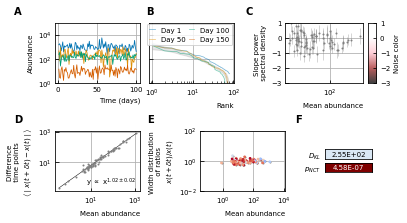

In [74]:
show_std=False
with_interactions=False
normalized=False

figfile = 'figures_elife/supplemental/logistic_model'
if with_interactions:
    figfile += '_interactions'
if normalized:
    figfile += '_normalized'
if show_std:
    figfile += '_std'
figfile += '.pdf'

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    
    example_figure(show_std, with_interactions, normalized)
    #plt.savefig(figfile)
    plt.show()